<a href="https://colab.research.google.com/github/AlpaslanErdag/Autonomous-Car-2022MLIS2/blob/main/EfficientNetB2_SpeedPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf; print(tf.__version__)

2.4.0


In [ ]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.4

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
     |████████████████████████████████| 394.7 MB 17 kB/s 
     |████████████████████████████████| 132 kB 93.0 MB/s 
     |████████████████████████████████| 14.8 MB 56.8 MB/s 
     |████████████████████████████████| 3.8 MB 56.1 MB/s 
     |████████████████████████████████| 462 kB 70.7 MB/s 
     |████████████████████████████████| 2.9 MB 63.8 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68724 sha256=580944ab2160e14fefea651f9a13aa25a7963e5e9791409492a303317448beeb
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: numpy
    Found ex

In [ ]:
!git clone https://github.com/AlpaslanErdag/cardata  # CLONING DATA FROM GITHUB

Cloning into 'cardata'...
remote: Enumerating objects: 14949, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 14949 (delta 25), reused 20 (delta 10), pack-reused 14897
Receiving objects: 100% (14949/14949), 1.64 GiB | 31.69 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Checking out files: 100% (14938/14938), done.


In [ ]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle
import seaborn as sns

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import *
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from tqdm import tqdm

tf.__version__: 2.4.0


In [ ]:
datadir= 'cardata'
colums= ['image_id','angle','speed']
Data=pd.read_csv(os.path.join(datadir,'training_norm3.csv'))


In [ ]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[50:,50:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (224, 224))
    img = img /255.0 
    #img = np.true_divide(image, 255, dtype=np.float32,casting="unsafe")
    return img

In [ ]:
### MODEL FOR SPEED PREDICTION ####
###################################
###################################

print(Data.iloc[13])
def load_speed_img(datadir, df):
  image_path1 = []
  speed1 = []
  for i in range(len(Data)):
    indexed_data = Data.iloc[i]
    image_id = indexed_data[0]
    image_path1.append(os.path.join(datadir,image_id))
    #angle.append(float(indexed_data[1]))
    speed1.append((indexed_data[2]))
  image_paths1 = np.asarray(image_path1)
  #angles = np.asarray(angle)
  speeds1= np.asarray(speed1)
  return image_paths1,speeds1

image_id    14.png
angle       0.8750
speed            1
Name: 13, dtype: object


In [ ]:
img_path,speeds1= load_speed_img(datadir + '/training_data/training_data', Data)

In [ ]:
########## PART 2###########
############################
print(Data.iloc[3])
def load_img_steering(datadir, df):
  image_path = []
  angle = []
  for i in range(len(Data)):
    indexed_data = Data.iloc[i]
    image_id = indexed_data[0]
    image_path.append(os.path.join(datadir,image_id))
    angle.append(float(indexed_data[1]))
    #speed.append((indexed_data[2]))
  image_paths = np.asarray(image_path)
  angles = np.asarray(angle)
  #speeds= np.asarray(speed)
  image_ids= np.asarray(image_id)
  return image_paths, angles

image_id    4.png
angle      0.6250
speed           1
Name: 3, dtype: object


In [ ]:
img_path1,angles= load_img_steering(datadir + '/training_data/training_data', Data)

In [ ]:
x_train_speed,x_valid_speed,y_train_speed,y_valid_speed= train_test_split(img_path,speeds1,test_size=0.2)
x_train_angle, x_valid_angle, y_train_angle, y_valid_angle = train_test_split(img_path1 , angles , test_size = 0.2)


Text(0.5, 1.0, 'Preprocessed Image')

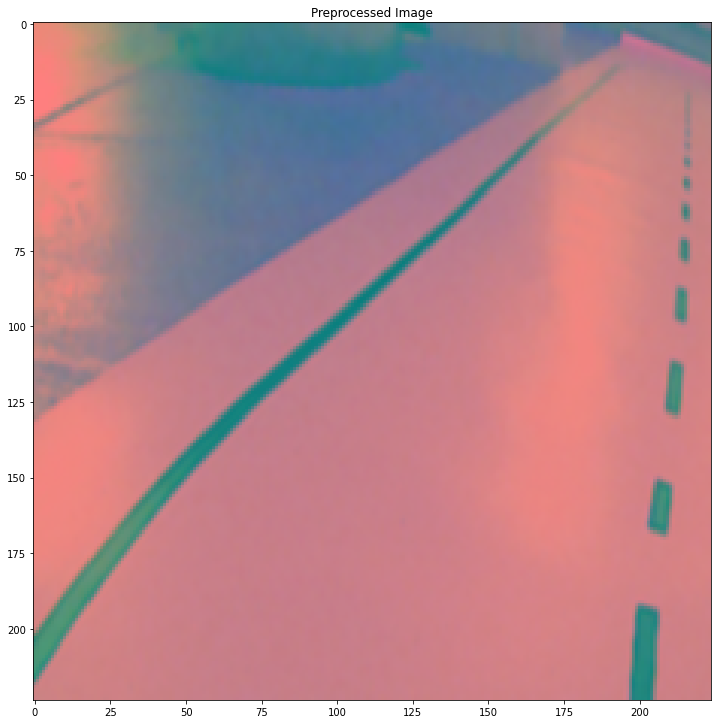

In [ ]:
image = img_path[165]
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 1, figsize=(15, 10))
fig.tight_layout()

axs.imshow(preprocessed_image)
axs.set_title('Preprocessed Image')

In [ ]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = random_augment(image_paths[random_index], steering_angles[random_index]) #use some image process(flip,zoom, pan etc...) randomly
            image = img_preprocess(image_path)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

In [ ]:
!pip install -U efficientnet


     |████████████████████████████████| 50 kB 4.6 MB/s 


In [ ]:
from tensorflow.keras import applications
help(applications)


Help on package tensorflow.keras.applications in tensorflow.keras:

NAME
    tensorflow.keras.applications - Keras Applications are canned architectures with pre-trained weights.

PACKAGE CONTENTS
    densenet (package)
    efficientnet (package)
    imagenet_utils (package)
    inception_resnet_v2 (package)
    inception_v3 (package)
    mobilenet (package)
    mobilenet_v2 (package)
    mobilenet_v3 (package)
    nasnet (package)
    resnet (package)
    resnet50 (package)
    resnet_v2 (package)
    vgg16 (package)
    vgg19 (package)
    xception (package)

FILE
    /usr/local/lib/python3.7/dist-packages/tensorflow/keras/applications/__init__.py




In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB2
Efficient_speed= EfficientNetB2(input_shape = (224,224,3),weights='imagenet',include_top=False,classes=2,classifier_activation="sigmoid")
Efficient_speed.trainable = False

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.regularizers import l1,l2
for layer in Efficient_speed.layers[290:]: 
    layer.trainable = True 
y = GlobalAveragePooling2D()(Efficient_speed.output)
y = Dense(1024, activation ='relu')(y)
y = Dense(256, activation ='relu')(y)
y = Dense(64, activation ='relu')(y)
y = Dense(32, activation ='relu')(y)

pred_speed = Dense(1)(y)

In [ ]:
from tensorflow.keras.models import Model
eff7_speed = Model(inputs = Efficient_speed.input,outputs=pred_speed)
eff7_speed.summary()
eff7_speed.compile(optimizer = 'adam',loss="mse",metrics=["mse"])
eff7_speed.optimizer.learning_rate = 0.000001

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 224, 224, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
normalization_8 (Normalization) (None, 224, 224, 3)  7           rescaling_8[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_8[0][0]            
___________________________________________________________________________________________

In [ ]:
history_new = eff7_speed.fit_generator(image_data_generator(x_train_speed, y_train_speed, batch_size=64),
                              steps_per_epoch=400, epochs=10,
                              validation_data = image_data_generator(x_valid_speed,y_valid_speed, batch_size=64),
                              validation_steps=300,verbose=1, shuffle=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
400/400 [==============================] - 360s 873ms/step - loss: 0.2280 - mse: 0.2280 - val_loss: 0.2090 - val_mse: 0.2090
Epoch 2/10
400/400 [==============================] - 347s 868ms/step - loss: 0.1479 - mse: 0.1479 - val_loss: 0.1287 - val_mse: 0.1287
Epoch 3/10
400/400 [==============================] - 347s 868ms/step - loss: 0.1063 - mse: 0.1063 - val_loss: 0.0839 - val_mse: 0.0839
Epoch 4/10
400/400 [==============================] - 347s 868ms/step - loss: 0.0840 - mse: 0.0840 - val_loss: 0.0638 - val_mse: 0.0638
Epoch 5/10
400/400 [==============================] - 346s 866ms/step - loss: 0.0669 - mse: 0.0669 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 6/10
400/400 [==============================] - 348s 870ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 7/10
400/400 [==============================] - 347s 869ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 8/10
400/400 [============================

Text(0.5, 0, 'Epoch')

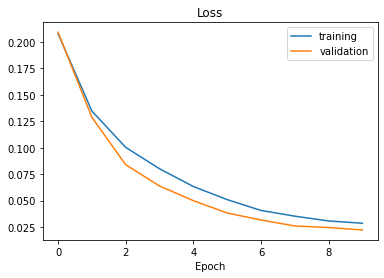

In [ ]:
plt.plot(history_new.history['loss'])
plt.plot(history_new.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
########## SAVING MODEL AND DOWNLOAD TO LOCAL #####
eff7_speed.save('modelforSpeed0505.h5')
from google.colab import files
files.download('modelforSpeed0505.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Mount my Google Drive.  It will ask for an authenticate code
### BEFORE THIS DONT FORGET TO UPLOAD MODEL FILE TO DRIVE
from google.colab import drive
drive.mount('/content/gdrive')
model_output_dir = '/content/gdrive/My Drive/Colab Notebooks'

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
modelSpeed = load_model(f'{model_output_dir}/modelforSpeed0505.h5')

In [ ]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
modelAngle = load_model(f'{model_output_dir}/modelforAngle0405.h5')

In [ ]:
import cv2
import matplotlib.image as mpimg
import numpy as np

def batch_generator_TEST(test_paths,NumberOfTestData):

  while True:
    batch_img = []
    
    for i in range(NumberOfTestData):
      im = mpimg.imread(test_paths[i])
      im = img_preprocess(im)
      batch_img.append(im)
          
    yield (np.asarray(batch_img))

In [ ]:
##############FOR REAL TEST DATA################
###############################################
#################################################
import pandas as pd

datadir= 'cardata'
colums= ['image_id1','angle1','speed1']
data1=pd.read_csv(os.path.join(datadir,'Test.csv'))
data1.head()

,image_id,angle,speed
0,1.png,NaN,NaN
1,2.png,NaN,NaN
2,3.png,NaN,NaN
3,4.png,NaN,NaN
4,5.png,NaN,NaN


In [ ]:
print(data1.iloc[13])
def load_test_img(datadir, df):
  test_path = []
  
  for i in range(len(data1)):
    indexed_data = data1.iloc[i]
    image_id = indexed_data[0]
    test_path.append(os.path.join(datadir,image_id))
    test_paths = np.asarray(test_path)
 
  return test_paths

test_paths= load_test_img(datadir + '/test_data/test_data', data1)

image_id    14.png
angle          NaN
speed          NaN
Name: 13, dtype: object


In [ ]:
def batch_generator_TEST(test_paths,NumberOfTestData):

  while True:
    batch_img = []
    
    for i in range(NumberOfTestData):
      im = mpimg.imread(test_paths[i])
      im = img_preprocess(im)
      batch_img.append(im)
          
    yield (np.asarray(batch_img))

In [ ]:
test_paths

array(['cardata/test_data/test_data/1.png',
       'cardata/test_data/test_data/2.png',
       'cardata/test_data/test_data/3.png', ...,
       'cardata/test_data/test_data/1018.png',
       'cardata/test_data/test_data/1019.png',
       'cardata/test_data/test_data/1020.png'], dtype='<U36')

In [ ]:
X_test=np.array(list(map(img_preprocess, test_paths)))


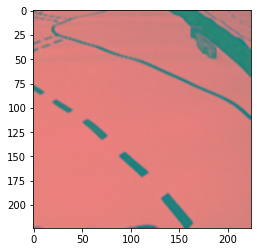

'cardata/test_data/test_data/3.png'

In [ ]:
import matplotlib.pyplot as plt

imgplot = plt.imshow(X_test[2])
plt.show()
test_paths[2]

In [ ]:
Speed_Pred = modelSpeed.predict(X_test)


In [ ]:
Speed_Pred

array([[0.0396],
       [0.9892],
       [0.7047],
       ...,
       [0.9638],
       [0.5123],
       [0.5574]], dtype=float32)

In [ ]:
Speed_Pred_r=np.around(Speed_Pred)

print(Speed_Pred_r)

[[0.0000]
 [1.0000]
 [1.0000]
 ...
 [1.0000]
 [1.0000]
 [1.0000]]


In [ ]:
pd.DataFrame(Speed_Pred_r).to_csv('Speed_Pred0505r.csv')